In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import matplotlib.colors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
import pandas as pd
import imageio
from IPython.display import HTML
import time


##data generation

In [ ]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["cyan","orange","black","blue"])

In [ ]:
data,labels = make_blobs(n_samples=1000,n_features=2,centers=4,random_state=0)
print(data.shape,labels.shape)

(1000, 2) (1000,)


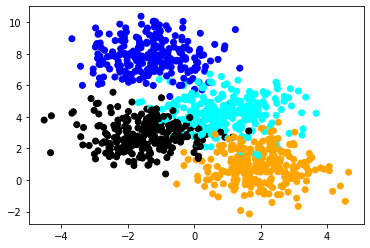

In [ ]:
plt.scatter(data[:,0],data[:,1],cmap=my_cmap,c=labels)
plt.show()

In [ ]:
np.random.seed(0)

In [ ]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)
W1
W2

array([[ 1.86755799, -0.97727788,  0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ,  0.14404357,  1.45427351]])

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(data,labels,stratify=labels,random_state=0)
print(X_train.shape,Y_val.shape)

(750, 2) (250,)


In [ ]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
Y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(Y_OH_train.shape, Y_OH_val.shape)

(750, 4) (250, 4)


##Vectorized FFclass

In [ ]:
class FFNetwork:
  
  def __init__(self, W1, W2):
        
    self.params={}
    self.params["W1"]=W1.copy()
    self.params["W2"]=W2.copy()
    self.params["B1"]=np.zeros((1,2))
    self.params["B2"]=np.zeros((1,4))
    self.num_layers=2
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
  
  def forward_activation(self, X): 
    return 1.0/(1.0 + np.exp(-X))
      
  def grad_activation(self, X):
    return X*(1-X) 

  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X, params = None):
    if params is None:
        params = self.params
    self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 4) -> (N, 4)
    self.H2 = self.softmax(self.A2) # (N, 4)
    return self.H2
  
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
  def fit(self, X, Y, epochs=1, algo= "GD", display_loss=False, 
          eta=1, mini_batch_size=100, eps=1e-8,  
          beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9 ):
      
    if display_loss:
      loss = {}
    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]
      
      if algo == "GD":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
          
      elif algo == "MiniBatch":
        for k in range(0,m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(1,self.num_layers+1):
            self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
            self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)
            
      elif algo == "Momentum":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
          self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]  
          
      elif algo == "NAG":
        temp_params = {}
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
          self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
          temp_params["W"+str(i)]=self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
          temp_params["B"+str(i)]=self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
        self.grad(X,Y,temp_params)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
          self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)]) 
        self.prev_update_params=self.update_params 
        
      elif algo == "AdaGrad":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
          self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)
      
      elif algo == "RMSProp":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] +(1-beta)*((self.gradients["dW"+str(i)]/m)**2)
          self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] +(1-beta)*((self.gradients["dB"+str(i)]/m)**2)
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)
      
      elif algo == "Adam":
        self.grad(X, Y)
        num_updates=0
        for i in range(1,self.num_layers+1):
          num_updates+=1
          self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
          self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
          m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
          v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["W"+str(i)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat
          
          self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
          self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
          m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
          v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
      if display_loss:
        Y_pred = self.predict(X)
        loss[num_epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
    
    if display_loss:
      loss_con = np.array(list(loss.values())).astype(float)
      plt.plot(loss_con, '-o', markersize=5)
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

In [ ]:
def print_accuracy():    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

##Fitting the model with different algorithms and hyperparameters

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


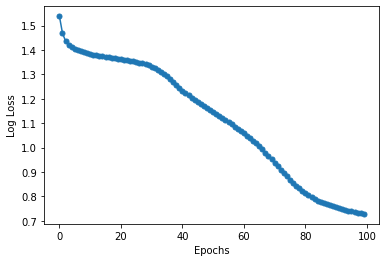

Training accuracy 0.7053
Validation accuracy 0.716
CPU times: user 341 ms, sys: 10.9 ms, total: 352 ms
Wall time: 365 ms


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="GD", display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


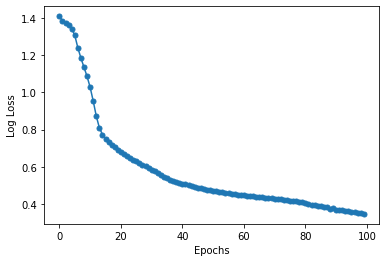

Training accuracy 0.8867
Validation accuracy 0.904
CPU times: user 373 ms, sys: 4.37 ms, total: 378 ms
Wall time: 404 ms


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=128, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


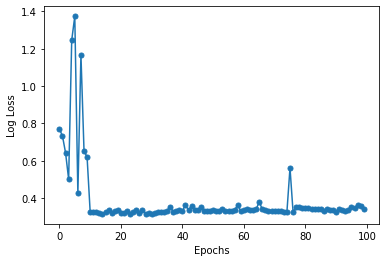

Training accuracy 0.8693
Validation accuracy 0.876
CPU times: user 1.01 s, sys: 9.98 ms, total: 1.02 s
Wall time: 1.05 s


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=8, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


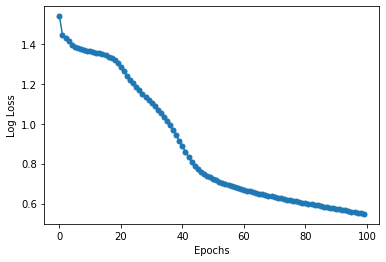

Training accuracy 0.8387
Validation accuracy 0.852
CPU times: user 330 ms, sys: 7.3 ms, total: 337 ms
Wall time: 344 ms


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.5, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


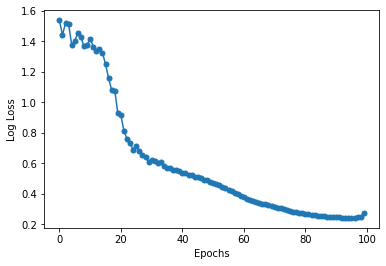

Training accuracy 0.8947
Validation accuracy 0.916
CPU times: user 344 ms, sys: 9.78 ms, total: 354 ms
Wall time: 355 ms


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


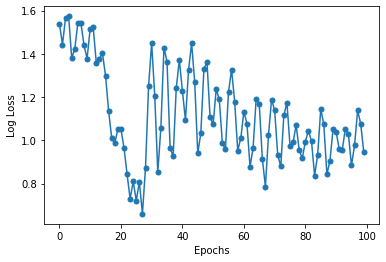

Training accuracy 0.6347
Validation accuracy 0.66
CPU times: user 343 ms, sys: 7.88 ms, total: 351 ms
Wall time: 356 ms


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.99, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


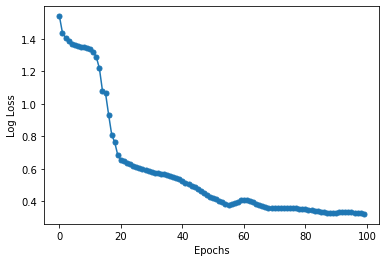

Training accuracy 0.88
Validation accuracy 0.872
CPU times: user 339 ms, sys: 6.03 ms, total: 345 ms
Wall time: 356 ms


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.99, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


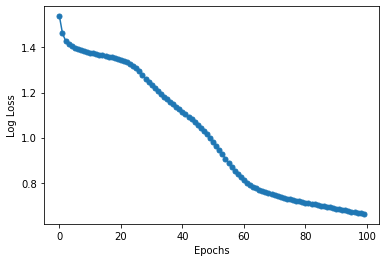

Training accuracy 0.704
Validation accuracy 0.728
CPU times: user 334 ms, sys: 11.1 ms, total: 345 ms
Wall time: 347 ms


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.5, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


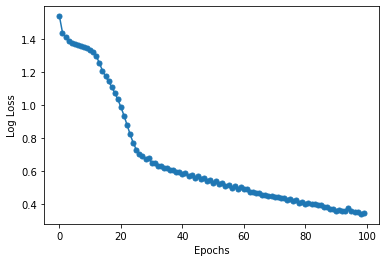

Training accuracy 0.8773
Validation accuracy 0.9
CPU times: user 351 ms, sys: 7.03 ms, total: 358 ms
Wall time: 365 ms


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


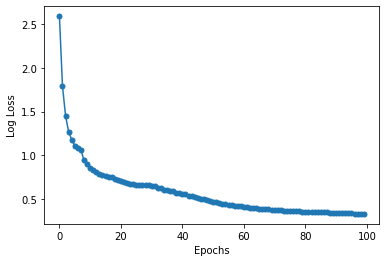

Training accuracy 0.88
Validation accuracy 0.904
CPU times: user 346 ms, sys: 8.73 ms, total: 355 ms
Wall time: 368 ms


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


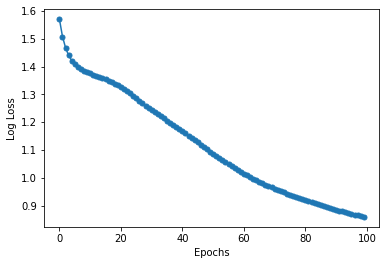

Training accuracy 0.644
Validation accuracy 0.636
CPU times: user 369 ms, sys: 4.15 ms, total: 373 ms
Wall time: 381 ms


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.1, algo="AdaGrad", display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


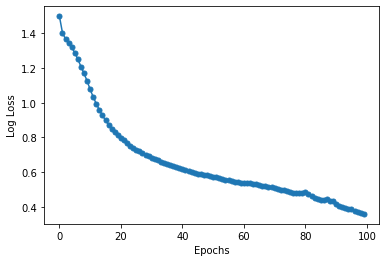

Training accuracy 0.8827
Validation accuracy 0.908
CPU times: user 351 ms, sys: 12.8 ms, total: 363 ms
Wall time: 388 ms


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.1, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


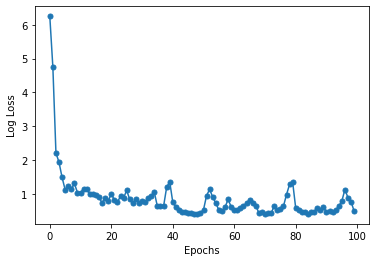

Training accuracy 0.8453
Validation accuracy 0.844
CPU times: user 348 ms, sys: 9.62 ms, total: 357 ms
Wall time: 357 ms


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.9, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


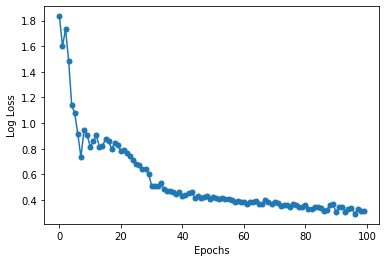

Training accuracy 0.8973
Validation accuracy 0.884
CPU times: user 364 ms, sys: 7.81 ms, total: 372 ms
Wall time: 380 ms


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.9, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


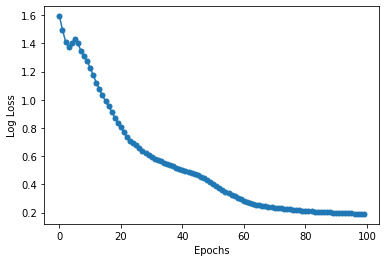

Training accuracy 0.9227
Validation accuracy 0.94
CPU times: user 459 ms, sys: 12.3 ms, total: 471 ms
Wall time: 473 ms


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.1, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()

##Good configurations for each algorithm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


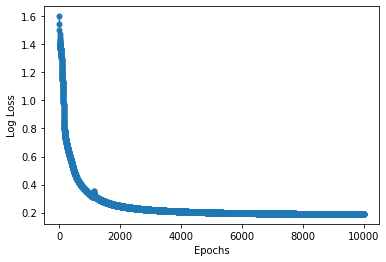

Training accuracy 0.9293
Validation accuracy 0.936
CPU times: user 14.3 s, sys: 56.4 ms, total: 14.3 s
Wall time: 14.4 s


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=10000, eta=0.5, algo="GD", display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


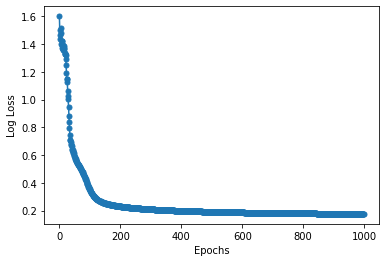

Training accuracy 0.9267
Validation accuracy 0.944
CPU times: user 1.63 s, sys: 8.5 ms, total: 1.64 s
Wall time: 1.66 s


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=1000, eta=0.5, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


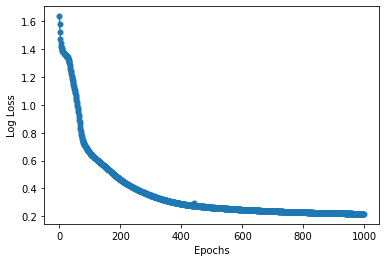

Training accuracy 0.9213
Validation accuracy 0.94
CPU times: user 1.6 s, sys: 8.08 ms, total: 1.61 s
Wall time: 1.65 s


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=1000, eta=0.5, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


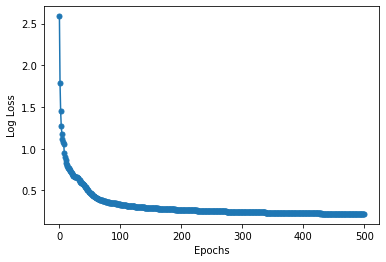

Training accuracy 0.912
Validation accuracy 0.936
CPU times: user 969 ms, sys: 11.8 ms, total: 981 ms
Wall time: 990 ms


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=500, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


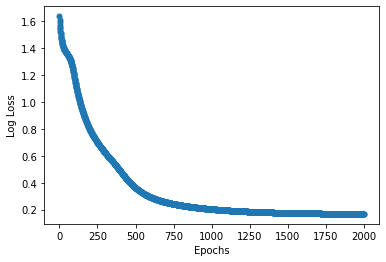

Training accuracy 0.9253
Validation accuracy 0.94
CPU times: user 3.15 s, sys: 22.7 ms, total: 3.17 s
Wall time: 3.21 s


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=2000, eta=.01, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


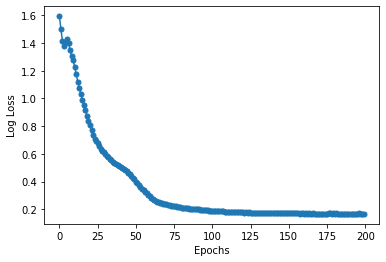

Training accuracy 0.9293
Validation accuracy 0.952
CPU times: user 481 ms, sys: 12 ms, total: 493 ms
Wall time: 523 ms


In [ ]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, Y_OH_train, epochs=200, eta=.1, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()